<a href="https://colab.research.google.com/github/RodriMenendez/BIO_LM_SURF/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install wandb

In [2]:
!wandb login

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import wandb
import time

## Data Preprocessing

In [4]:
path = '/content/drive/MyDrive/SURF_2023/Practice'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = torchvision.datasets.CIFAR10(root=path+'/cifar10', train=True, transform=transform, download=True)

batch_size = 32
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
test_data = torchvision.datasets.CIFAR10(root=path+'/cifar10', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Image Example

Text(0.5, 1.0, 'deer')

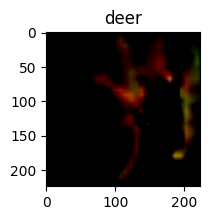

In [7]:
i = np.random.randint(0, high=len(train_data))

plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_data[i][0]).T)
plt.title(classes[train_data[i][1]])

## RestNet tutorial
Link: https://pytorch.org/hub/pytorch_vision_resnet/ \
Downloding model and getting output

In [8]:
model = torchvision.models.resnet18(weights='DEFAULT')
# pre-trained model weights kept constant
for param in model.parameters():
    param.requires_grad = False

In [9]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-06-29 02:30:52--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.2’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-06-29 02:30:52 (69.0 MB/s) - ‘imagenet_classes.txt.2’ saved [10472/10472]



In [10]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [11]:
j = np.random.randint(0, high=len(train_data))
test_probabilities = nn.functional.softmax(model(torch.reshape(train_data[j][0], (1, 3, 224, 224))), dim=1)

In [12]:
# Show top categories per image
top5_prob, top5_catid = torch.topk(test_probabilities, 10)
top5_catid = torch.reshape(top5_catid, (10,))
top5_prob = torch.reshape(top5_prob, (10,))

In [13]:
for i in range(top5_prob.size(0)):
    print(f'Category: {categories[top5_catid[i]]}\t\t', f'Probability: {top5_prob[i].item():.2}')

Category: bucket		 Probability: 0.0083
Category: plunger		 Probability: 0.0068
Category: hook		 Probability: 0.0063
Category: ashcan		 Probability: 0.0056
Category: water jug		 Probability: 0.0054
Category: water bottle		 Probability: 0.0053
Category: paper towel		 Probability: 0.0049
Category: tennis ball		 Probability: 0.0049
Category: pole		 Probability: 0.0048
Category: ladle		 Probability: 0.0047


Text(0.5, 1.0, 'dog')

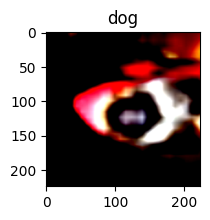

In [14]:
plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_data[j][0]).T)
plt.title(classes[train_data[j][1]])

## Adding Classification Head

In [15]:
class Classification(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained_model = pretrained_model
        self.layer1 = nn.Linear(1000, 100)
        self.layer2 = nn.Linear(100, 10)

    def probabilities(self, x):
        output =  self.pretrained_model(x)
        output = F.relu(self.layer1(output))
        output = F.softmax(self.layer2(output), dim=1)

        return output

    def forward(self, x):
        output = self.probabilities(x)
        output = torch.argmax(output, dim=1)

        return output

In [16]:
clf_model = Classification(model)
if torch.cuda.is_available():
    clf_model.cuda()

In [17]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 185})'''))
summary(clf_model, input_size=(3, 224, 224))

<IPython.core.display.Javascript object>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
lr = 1e-3
momentum = 0.9

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_model.parameters(), lr=lr, momentum=momentum)

In [19]:
def train_step(trainloader, model):
    correct = 0
    step_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        one_hot_labels = F.one_hot(labels, 10)

        # zero parameter gradients
        optimizer.zero_grad()

        # update values
        output = model.probabilities(inputs)
        loss = loss_func(output, one_hot_labels.float())
        step_loss += loss
        loss.backward()
        optimizer.step()

        # get classification accuracy
        accuracy_output = model(inputs)
        correct += (accuracy_output == labels).float().sum()

    step_loss /= len(trainloader)
    return step_loss, correct

def test_step(testloader, model):
    correct = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        output = model(inputs)

        correct += (output == labels).float().sum()

    return correct

In [20]:
epochs = 20

wandb.init(
    project = "CIFAR10-Resnet18-Classification",
    config={
        "learning rate": lr,
        "momentum": momentum,
        "epochs": epochs,
        "dataset": "CIFAR10",
        "architecture": "Resnet18"
    }
)

for t in range(epochs):
    loss, train_correct = train_step(trainloader, clf_model)
    train_accuracy = train_correct/len(train_data)

    test_correct = test_step(testloader, clf_model)
    test_accuracy = test_correct/len(test_data)

    print(f'|Epoch: {t}\t|Loss: {loss:.3}\t|Train Accuracy: {train_accuracy:.3}\t|Test Accuracy: {test_accuracy:.3}')

    wandb.log({"train_acc": train_accuracy, "test_acc": test_accuracy, "loss": loss})

wandb: Currently logged in as: aavelarm (surf-2023). Use `wandb login --relogin` to force relogin


|Epoch: 0	|Loss: 1.92	|Train Accuracy: 0.589	|Test Accuracy: 0.692
|Epoch: 1	|Loss: 1.77	|Train Accuracy: 0.717	|Test Accuracy: 0.72
|Epoch: 2	|Loss: 1.74	|Train Accuracy: 0.734	|Test Accuracy: 0.732
|Epoch: 3	|Loss: 1.73	|Train Accuracy: 0.742	|Test Accuracy: 0.738
|Epoch: 4	|Loss: 1.72	|Train Accuracy: 0.748	|Test Accuracy: 0.74
|Epoch: 5	|Loss: 1.72	|Train Accuracy: 0.754	|Test Accuracy: 0.744
|Epoch: 6	|Loss: 1.71	|Train Accuracy: 0.757	|Test Accuracy: 0.745
|Epoch: 7	|Loss: 1.71	|Train Accuracy: 0.758	|Test Accuracy: 0.749
|Epoch: 8	|Loss: 1.71	|Train Accuracy: 0.761	|Test Accuracy: 0.753
|Epoch: 9	|Loss: 1.71	|Train Accuracy: 0.763	|Test Accuracy: 0.752
|Epoch: 10	|Loss: 1.7	|Train Accuracy: 0.766	|Test Accuracy: 0.752
|Epoch: 11	|Loss: 1.7	|Train Accuracy: 0.768	|Test Accuracy: 0.749
|Epoch: 12	|Loss: 1.7	|Train Accuracy: 0.767	|Test Accuracy: 0.755
|Epoch: 13	|Loss: 1.7	|Train Accuracy: 0.772	|Test Accuracy: 0.756
|Epoch: 14	|Loss: 1.7	|Train Accuracy: 0.774	|Test Accuracy: 0.7

In [21]:
wandb.finish()

loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test_acc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇█████
train_acc,▁▆▆▇▇▇▇▇▇▇▇█████████
loss,1.68884
test_acc,0.7632
train_acc,0.78006


In [22]:
timestr = time.strftime("%Y%m%d-%H%M%S")

path = '/content/drive/MyDrive/SURF_2023/Practice/models/clf_model' + timestr
torch.save(clf_model.state_dict(), path)

In [23]:
## using model
# clf_model = Classification(model)
# clf_model.load_state_dict(torch.load(path))